# Comparing Deep Learning Models for Sales Forecasting using Covalent

## Summary
In this example, we use Covalent to orchestrate a workflow which compares the performances of four different deep learning models -- the multi-layer perceptron (MLP) model, the convolutional neural network (CNN) model, the long short-term memory (LSTM) model, and a hybrid CNN-LSTM model. Each neural network is trained on daily historical sales data spanning four years. Covalent allows us to easily deploy different tasks to different hardware resources.

<img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Store%20Item%20Demand%20Forecasting%20Challenge/time-series%20graph.png" width="800">

![](https://raw.githubusercontent.com/AgnostiqHQ/covalent/master/doc/source/_static/cova_archi.png)

### Tasks in this example are heterogeneous in several ways:
* Task Scheduling: Dask / ECS Fargate / AWS Batch
* Execution Backend: Local / Remote CPU

### The workflow performs the following steps:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.center {
  margin-left: auto;
  margin-right: auto;
}
</style>
<table class="tg center">
<thead>
  <tr>
    <th class="tg-0pky"><b>Task</b></th>
    <th class="tg-0pky"><b>Resources</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">Fetch and validate a training dataset from a remote machine</td>
    <td class="tg-0pky">
    <img src="https://numfocus.org/wp-content/uploads/2017/11/dask-logo-300.png"  alt="1" width = 40px height = 40px >
    <img src="https://toppng.com/uploads/preview/laptop-icon-png-transparent-11553368414dlflmgculs.png"  alt="1" width = 40px height = 40px >
    </td>
  </tr>
  <tr>
    <td class="tg-0pky">Explore the dataset and visualize broad trends</td>
    <td class="tg-0pky">
    <img src="https://numfocus.org/wp-content/uploads/2017/11/dask-logo-300.png"  alt="1" width = 40px height = 40px >
    <img src="https://toppng.com/uploads/preview/laptop-icon-png-transparent-11553368414dlflmgculs.png"  alt="1" width = 40px height = 40px >
    </td>
  </tr>
  <tr>
    <td class="tg-0pky">Clean / transform the data</td>
    <td class="tg-0pky">
    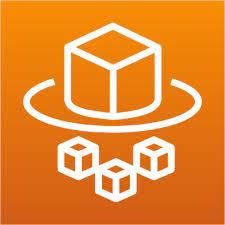
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSjG2XseaE9MMUb-v-7_Bae1oVwNC9EUyfhog&usqp=CAU"  alt="1" width = 40px height = 40px >
    </td>
  </tr>
  <tr>
    <td class="tg-0pky">Split the Data for Training and Validation</td>
    <td class="tg-0pky">
    <img src="https://numfocus.org/wp-content/uploads/2017/11/dask-logo-300.png"  alt="1" width = 40px height = 40px >
    <img src="https://toppng.com/uploads/preview/laptop-icon-png-transparent-11553368414dlflmgculs.png"  alt="1" width = 40px height = 40px >
    </td>
  </tr>
  <tr>
    <td class="tg-0pky">Construct the DNN Models</td>
    <td class="tg-0pky">
    <img src="https://numfocus.org/wp-content/uploads/2017/11/dask-logo-300.png"  alt="1" width = 40px height = 40px >
    <img src="https://toppng.com/uploads/preview/laptop-icon-png-transparent-11553368414dlflmgculs.png"  alt="1" width = 40px height = 40px >
    </td>
  </tr>
  <tr>
    <td class="tg-0pky">Train the Models</td>
    <td class="tg-0pky">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Slurm_logo.svg/2238px-Slurm_logo.svg.png"  alt="1" width = 40px height = 40px >
    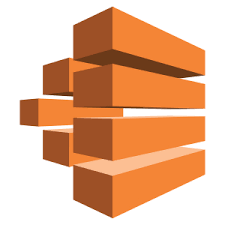
    <img src="https://cdn-icons-png.flaticon.com/512/1089/1089003.png"  alt="1" width = 40px height = 40px >
    </td>
  </tr>
  <tr>
    <td class="tg-0pky">Visualize the results</td>
    <td class="tg-0pky">
    <img src="https://numfocus.org/wp-content/uploads/2017/11/dask-logo-300.png"  alt="1" width = 40px height = 40px >
    <img src="https://toppng.com/uploads/preview/laptop-icon-png-transparent-11553368414dlflmgculs.png"  alt="1" width = 40px height = 40px >
    </td>
  </tr>
</tbody>
</table>

This tutorial is derived from work by Dimitre Oliveira on [Kaggle](https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/).

In [ ]:
# Imports
import covalent as ct

import warnings
import numpy as np
import pandas as pd
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from typing import List

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

### We run the first task, which fetches and validates input data

In [ ]:
remote_train_file = ct.fs.File('/Users/faiyaz/Code/datasets_2/train.csv')
remote_test_file = ct.fs.File('/Users/faiyaz/Code/datasets_2/test.csv')
local_train_file = ct.fs.File('/Users/faiyaz/Code/datasets/train.csv')
local_test_file = ct.fs.File('/Users/faiyaz/Code/datasets/test.csv')

@ct.electron(
    files=[
        ct.fs.FileTransfer(remote_train_file, local_train_file, order=ct.fs.Order.BEFORE),
        ct.fs.FileTransfer(remote_test_file, local_test_file, order=ct.fs.Order.BEFORE),
    ]
)
def fetch_and_validate_data(files=[]) -> List[str]:
    _, local_train = files[0]
    _, local_test = files[1]
    train = pd.read_csv(local_train, parse_dates=['date'])
    test = pd.read_csv(local_test, parse_dates=['date'])
    return train


### Next, explore the dataset and visualize basic trends

In [ ]:
@ct.electron
def explore_data(dataset):
    # Aggregate daily sales
    daily_sales = dataset.groupby('date', as_index=False)['sales'].sum()
    store_daily_sales = dataset.groupby(['store', 'date'], as_index=False)['sales'].sum()
    item_daily_sales = dataset.groupby(['item', 'date'], as_index=False)['sales'].sum()
    
    # Plot total daily sales
    daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
    layout1 = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
    fig1 = go.Figure(data=[daily_sales_sc], layout=layout1)
    
    # Sales by item
    item_daily_sales_sc = []
    for item in item_daily_sales['item'].unique():
        current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
        item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

    layout2 = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
    fig2 = go.Figure(data=item_daily_sales_sc, layout=layout2)
    
    return fig1, fig2

### Now we subsample and transform the data to a period of interest. We use the last year of data and for each date, use the previous month to forecast 90 days ahead.  In addition, this task will run on AWS Fargate on ECS.

In [ ]:
fargate_executor = ct.executor.ECSExecutor(
    credentials="/Users/faiyaz/.aws/credentials",
    region="us-east-1",
    profile="default",
    s3_bucket_name="covalent-fargate-task-resources",
    ecr_repo_name="covalent-fargate-task-images",
    ecs_cluster_name="covalent-fargate-cluster",
    ecs_task_family_name="covalent-fargate-tasks",
    ecs_task_execution_role_name="ecsTaskExecutionRole",
    ecs_task_role_name = "CovalentFargateTaskRole",
    ecs_task_subnet_id="subnet-871545e1",
    ecs_task_security_group_id="sg-0043541a",
    ecs_task_log_group_name="covalent-fargate-task-logs",
    vcpu=4,
    memory=8,
    retry_attempts=2,
    poll_freq=10,
    time_limit=3000,
    cache_dir="/tmp/covalent"
)

In [ ]:
# deps_pip = ct.DepsPip(packages=["pandas==1.4.4"])

# @ct.electron(
#     deps_pip=deps_pip,
#     executor=fargate_executor
# )
@ct.electron
def transform_data(dataset, window, lag_size):
    # Subsample
    refined_data = dataset[(dataset['date'] >= '2017-01-01')]
    
    # Restructure
    group = refined_data.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
    group = group.agg({'sales':['mean']})
    group.columns = ['item', 'store', 'date', 'sales']
    
    data = group.drop('date', axis=1)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
        
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    # Target timestep (t=lag)
    cols.append(data.shift(-lag_size))
    names += [('%s(t+%d)' % (col, lag_size)) for col in data.columns]
    
    # Put it all together
    time_series = pd.concat(cols, axis=1)
    time_series.columns = names
    
    # Drop rows with NaN values
    time_series.dropna(inplace=True)
    
    # Filter unwanted data
    last_item = 'item(t-%d)' % window
    last_store = 'store(t-%d)' % window
    time_series = time_series[(time_series['store(t)'] == time_series[last_store])]
    time_series = time_series[(time_series['item(t)'] == time_series[last_item])]
    
    columns_to_drop = [('%s(t+%d)' % (col, lag_size)) for col in ['item', 'store']]
    for i in range(window, 0, -1):
        columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    time_series.drop(columns_to_drop, axis=1, inplace=True)
    time_series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
    
    return time_series

In [ ]:
# Split the time series into training / validation sets
@ct.electron
def split_data(time_series, lag_size):
    # Label
    labels_col = 'sales(t+%d)' % lag_size
    labels = time_series[labels_col]
    time_series = time_series.drop(labels_col, axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(time_series, labels.values, test_size=0.4, random_state=0)
    X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    
    return X_train, X_train_series, X_valid, X_valid_series, Y_train, Y_valid

### Next frame contruction of the four DNN models as tasks.

In [ ]:
@ct.electron
def construct_mlp_model(X_train):
    model_mlp = Sequential()
    model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model_mlp.add(Dense(1))
    
    return model_mlp

In [ ]:
@ct.electron
def construct_cnn_model(X_train_series, X_valid_series):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(
        filters=64, 
        kernel_size=2, 
        activation='relu', 
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    ))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(50, activation='relu'))
    model_cnn.add(Dense(1))
    
    return model_cnn

In [ ]:
@ct.electron
def construct_lstm_model(X_train_series, X_valid_series):
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
    model_lstm.add(Dense(1))
    
    return model_lstm

In [ ]:
@ct.electron
def construct_cnn_lstm_model(X_train_series, X_valid_series):
    subsequences = 2
    timesteps = X_train_series.shape[1]//subsequences
    X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
    X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
    
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(
        filters=64, 
        kernel_size=1, 
        activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(50, activation='relu'))
    model_cnn_lstm.add(Dense(1))
    
    return model_cnn_lstm

### Define tasks which train / fit the four models. We will offload these to two different remote backends: two go to a Slurm-based cluster, two go to AWS Batch. This allows us to distribute work to multiple regions in the cloud.

In [ ]:
batch_executor = ct.executor.AWSBatchExecutor(
    credentials="/Users/faiyaz/.aws/credentials",
    batch_queue="covalent-batch-queue",
    profile="default",
    s3_bucket_name="covalent-batch-job-resources",
    batch_job_definition_name="covalent-batch-jobs",
    batch_execution_role_name="ecsTaskExecutionRole",
    batch_job_role_name="CovalentBatchJobRole",
    batch_job_log_group_name="covalent-batch-job-logs",
    vcpu=4,
    memory=8,
    retry_attempts=2,
    poll_freq=10,
    time_limit=3000,
    cache_dir="/tmp/covalent"
)

In [ ]:
# deps_pip = ct.DepsPip(packages=["tensorflow==2.9.1", "pandas==1.4.4"])

# @ct.electron(
#     deps_pip=deps_pip,
#     executor=batch_executor
# )
@ct.electron
def fit_mlp_model(model_mlp, X_train, X_valid, Y_train, Y_valid, learning_rate, epochs):
    model_mlp.compile(loss='mse', optimizer=optimizers.Adam(learning_rate))
    
    return model_mlp.fit(
        X_train.values, 
        Y_train, 
        validation_data=(X_valid.values, Y_valid), 
        epochs=epochs
)

In [ ]:
# deps_pip = ct.DepsPip(packages=["tensorflow==2.9.1", "pandas==1.4.4"])

# @ct.electron(
#     deps_pip=deps_pip,
#     executor=batch_executor
# )
@ct.electron
def fit_cnn_model(model_cnn, X_train_series, X_valid_series, Y_train, Y_valid, learning_rate, epochs):
    model_cnn.compile(loss='mse', optimizer=optimizers.Adam(learning_rate))
    
    return model_cnn.fit(
        X_train_series, 
        Y_train, 
        validation_data=(X_valid_series, Y_valid), 
        epochs=epochs
    )

In [ ]:
# @ct.electron(
#     deps_pip=deps_pip,
#     executor=batch_executor
# )
@ct.electron
def fit_lstm_model(model_lstm, X_train_series, X_valid_series, Y_train, Y_valid, learning_rate, epochs):
    model_lstm.compile(loss='mse', optimizer=optimizers.Adam(learning_rate))
    
    return model_lstm.fit(
        X_train_series, 
        Y_train, 
        validation_data=(X_valid_series, Y_valid), 
        epochs=epochs
    )

In [ ]:
# @ct.electron(
#     deps_pip=deps_pip,
#     executor=batch_executor
# )
@ct.electron
def fit_cnn_lstm_model(model_cnn_lstm,  X_train_series, X_valid_series, Y_train, Y_valid, learning_rate, epochs):
    model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(learning_rate))
    
    subsequences = 2
    timesteps = X_train_series.shape[1]//subsequences
    X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
    X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
    
    return model_cnn_lstm.fit(
        X_train_series_sub, 
        Y_train, 
        validation_data=(X_valid_series_sub, Y_valid), 
        epochs=epochs
    )

In [ ]:
@ct.electron
def visualize_loss_functions(mlp_history, cnn_history, lstm_history, cnn_lstm_history):    
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(22,12))
    ax1, ax2 = axes[0]
    ax3, ax4 = axes[1]

    ax1.plot(mlp_history.history['loss'], label='Train loss')
    ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('MLP')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE')

    ax2.plot(cnn_history.history['loss'], label='Train loss')
    ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
    ax2.legend(loc='best')
    ax2.set_title('CNN')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')

    ax3.plot(lstm_history.history['loss'], label='Train loss')
    ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
    ax3.legend(loc='best')
    ax3.set_title('LSTM')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MSE')

    ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
    ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
    ax4.legend(loc='best')
    ax4.set_title('CNN-LSTM')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('MSE')
    plt.savefig("/Users/faiyaz/Code/covalent/doc/source/tutorials/machine_learning/images/comparison.png")
    

### We are now ready to construct a workflow which compares four DNN models using a variety of cloud-based compute resources

In [ ]:
@ct.lattice
def compare_models(window, lag_size, learning_rate, epochs):
    # Fetch and validate source data
    train = fetch_and_validate_data()
    
    # Explore the data
    daily_sales_plt, sales_by_item_plt = explore_data(train)
    
    # Subsample and transform the data
    time_series = transform_data(train, window, lag_size)

    # Split into training and validation sets
    X_train, X_train_series, X_valid, X_valid_series, Y_train, Y_valid = split_data(time_series, lag_size)
    
    # Construct the models
    model_mlp = construct_mlp_model(X_train)
    model_cnn = construct_cnn_model(X_train_series=X_train_series, X_valid_series=X_valid_series)
    model_lstm = construct_lstm_model(X_train_series=X_train_series, X_valid_series=X_valid_series)
    model_cnn_lstm = construct_cnn_lstm_model(X_train_series=X_train_series, X_valid_series=X_valid_series)
    
    # Train the models
    mlp_history = fit_mlp_model(model_mlp=model_mlp, X_train=X_train, X_valid=X_valid, Y_train=Y_train, Y_valid=Y_valid, learning_rate=learning_rate, epochs=epochs)
    cnn_history = fit_cnn_model(model_cnn=model_cnn, X_train_series=X_train_series, X_valid_series=X_valid_series, Y_train=Y_train, Y_valid=Y_valid, learning_rate=learning_rate, epochs=epochs)
    lstm_history = fit_lstm_model(model_lstm=model_lstm, X_train_series=X_train_series, X_valid_series=X_valid_series, Y_train=Y_train, Y_valid=Y_valid, learning_rate=learning_rate, epochs=epochs)
    cnn_lstm_history = fit_cnn_lstm_model(model_cnn_lstm=model_cnn_lstm, X_train_series=X_train_series, X_valid_series=X_valid_series, Y_train=Y_train, Y_valid=Y_valid, learning_rate=learning_rate, epochs=epochs)
    visualize_loss_functions(mlp_history, cnn_history, lstm_history, cnn_lstm_history)
    
    return mlp_history, cnn_history, lstm_history, cnn_lstm_history
    

### Time to invoke the workflow!

In [ ]:
dispatch_id = ct.dispatch(compare_models)(
    window=29,
    lag_size=90,
    learning_rate=0.0003,
    epochs=40
)

print(dispatch_id)

### You are now free to kill the Python kernel, take a walk, and come back when your workflow is done running.  Want reminders? Ask about e-mail or Slack notifications upon completion/failure...

### But first, let's now take a look at the UI in the browser...

![](workflow.png)

In [ ]:
res = ct.get_result(dispatch_id, wait=True)

In [ ]:
print(f"Workflow status: {res.status} \nComputation time: {((res.end_time - res.start_time).total_seconds() / 60):.1f} minutes")

### Finally, let's visualize the loss functions for each of the models as they trained